# ODE  model of NeuroImaging with Bayesian Inference in Numpyro

**Date: April 12, 2024
**Tags: ODE model in Nympyro
**Category: Advanced, how-to
**Authors: Meysam HASHEMI, INS, AMU, Marseille

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
import jax 
import jax.numpy as jnp
from jax import grad, vmap, lax, random
from jax.experimental.ode import odeint
from jax.lib import xla_bridge

In [3]:
import numpyro as npr
from numpyro import sample, plate, handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_value

In [4]:
import os
import multiprocessing

#set up for parallelizing the chains

def setup_parallelization():
    num_cores = multiprocessing.cpu_count()
    os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={num_cores}"
    jax.config.update("jax_enable_x64", True)
    jax.config.update("jax_platform_name", "cpu")
    print(f"Number of CPU cores: {num_cores}")
    print(f"Using devices: {jax.devices('cpu')}")

In [5]:
import matplotlib.ticker as plticker

def modify_axis_spines(ax, which=None, base=1.0, xticks=[], yticks=[], yaxis_left=True, xaxis_bot=True):

    tick_locator = plticker.MultipleLocator(base=base)

    if yaxis_left: 
        ax.spines.right.set(visible=False)
        yspine = ax.spines.left
    else:
        ax.spines.left.set(visible=False)
        yspine = ax.spines.right
        
    if xaxis_bot:
        ax.spines.top.set(visible=False)
        xspine = ax.spines.bottom
    else:
        ax.spines.bottom.set(visible=False)
        xspine = ax.spines.top
                           
    if 'x' in which:
        if len(xticks) == 0:
            xticks = ax.get_xticks() 
            ax.xaxis.set_major_locator(tick_locator)
        ax.set_xticks(xticks)
        xspine.set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])
        
    else:
        ax.spines.bottom.set(visible=False)
    
    if 'y' in which:
        if len(yticks) == 0:
            yticks = ax.get_yticks()
        ax.set_yticks(yticks)
        yspine.set_bounds(ax.get_yticks()[0], ax.get_yticks()[-1])
        if len(yticks) == 0:
            ax.yaxis.set_major_locator(tick_locator)
    else:
        ax.spines.left.set(visible=False)

def fmt_plot_text(text):
    return f'{text:.2f}'

def get_source_time_label(time_value):
    return 'Time from ball movement: {} ms'.format(np.round(time_value*1000))

In [6]:
enable_parallelization = True

if enable_parallelization:
    setup_parallelization()
    print("Parallelizing chains.")
else:
    print("Skipping parallelization setup.")

Number of CPU cores: 16
Using devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]
Parallelizing chains.


In [7]:
npr.set_platform("cpu")

In [8]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.24.3
JAX version: 0.4.25
Numpyro version: 0.13.2
Arviz version: 0.16.1


In [9]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [10]:
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [ ]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

output_dir= cwd + '/output_numpyro/'
! mkdir -p $output_dir

fig_save_loc = ''

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

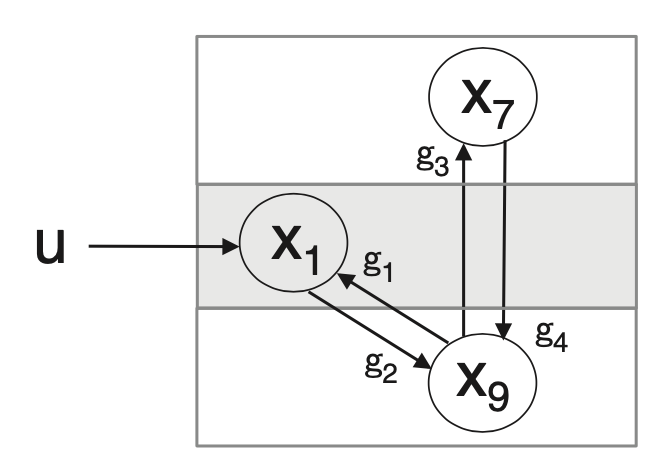

In [12]:
from IPython.display import Image
Image(filename='model.png', width=400)

## Simulator

In [13]:
from ERPmodel_EC_JAX import DCM_EC_ERPmodel, odeint_euler, odeint_heun, odeint_rk4

In [284]:
from jax import random
rng_key = random.PRNGKey(0)

In [625]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [626]:
ns = 9
x_init=np.zeros((ns))

In [ ]:
theta_true = np.array([0.1, 0.7, 0.15, 0.2])
n_params = theta_true.shape[0]

In [628]:
prm_names = ['g_1', 'g_2', 'g_3', 'g_4']

Run the model

In [629]:
%%time
xs_euler = odeint_euler(DCM_EC_ERPmodel, x_init, ts, theta_true)

CPU times: user 56.7 ms, sys: 0 ns, total: 56.7 ms
Wall time: 52.9 ms


We use Euler integration (see the ForwardModel for Heun and Rk4 integratores), But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [630]:
@jax.jit
def ERP_JAXOdeintSimulator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_EC_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [631]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)

print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.05692148208618164


In [632]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)

print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.0004940032958984375


## Synthetic Observation

We assume that we only have access to the activity of pyramidal neurons, and for the sake of speeding the computational time, we downsample the simuations.

In [633]:
#observation noise
sigma_true = 0.1

In [634]:
xpy_jax = ERP_JAXOdeintSimulator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [635]:
#downsampling
ds=10

In [636]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [637]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [638]:
data= { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

In [639]:
from ERPmodel_helperplot import *

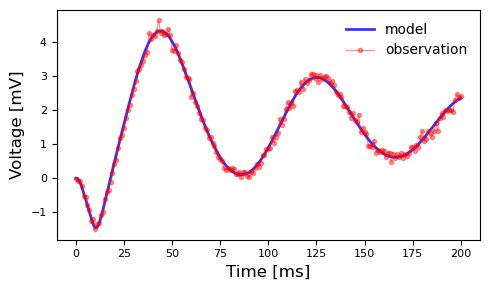

In [640]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs);
# plt.savefig(os.path.join((output_dir),"Observation.png"), dpi=400)

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [ ]:
shape=[18.16, 29.9, 29.14, 30.77]
scale=[0.03, 0.02, 0.005, 0.007]

rate = 1. / np.array(scale)

In [642]:
prior_specs = dict(shape=shape, rate=rate)

In [643]:
def model(data, prior_specs):
    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    xpy_obs = data['xpy_obs']

    # Prior               
    g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))

    #Parameters    
    params_samples=[g_1, g_2, g_3, g_4]
    
    #Forward model
    xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]
    
    # Likelihood
    with plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        npr.sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=xpy_obs)
        xpy_ppc = npr.sample('xpy_ppc', dist.Normal(xpy_model, obs_err))

In [ ]:
with npr.handlers.seed(rng_seed=1):
    trace = npr.handlers.trace(model).get_trace(data, prior_specs)
print(npr.util.format_shapes(trace))

### Prior predictive check

In [645]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

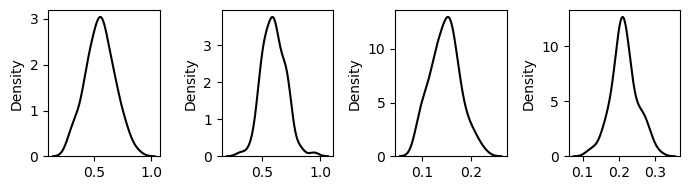

In [646]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(7, 2))
for iprm, prm in enumerate(prm_names):
    sns.kdeplot(prior_predictions[prm], color='k', ax=ax[iprm]);
fig.tight_layout()

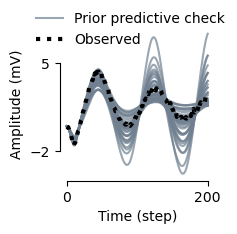

In [841]:
fig, ax = plt.subplots(figsize=(2,2))

markersize=10
lw=3
tend = data['nt_obs']-1

ax.plot(prior_predictions['xpy_model'].T[:,::3], label='Prior predictive check', color='slategray', alpha=0.7, lw=1.5)
ax.plot(xpy_obs, lw=lw, label='Observed', c=truth_color, ls='dotted')

handles,labels = ax.get_legend_handles_labels()

modify_axis_spines(ax, which=['x','y'], xticks=[0, tend], yticks=[xpy_obs.min().round()-1, xpy_obs.max().round()])
    
ax.set_xlabel('Time (step)')
ax.set_ylabel('Amplitude (mV)')

fig.legend(handles[-2:], labels[-2:], frameon=False)
fig.savefig(fig_save_loc + '/ERP/Numpyro_validation_prior.svg', transparent=True)

## NUTS sampling 

 Due to large dimentionality of problem and the nonlinear relation between parameeters, the multimodality is omnipresence in this case. In the follwing , we run 4 NUTS chains with default configurations that operates across diverse problems, but not necessarliy leads to convergence. Then we tune the algorithmic parameetrs for better convergence, however, resulting in multimodality. Finnaly, we propose the weighted stacking the chains as a solution to deal with this challnge. 

NOTES: By default set-up, the chains may converge or not. In particular, it may be seen that some samples hits the max tree-depth, which then lead to no convergence. The convergence can be checked by monitoring the \hat R, close to 1 as a rule of thumb, also the Rank Plot, and Effective Sample Size (EES) which we will see in the following.

Now we run the chains at the tail of prior to get convergence for all chains.

In [756]:
n_warmup, n_samples, n_chains= 200, 1000, 4

In [757]:
# NUTS set up
kernel = NUTS(model, max_tree_depth=12, dense_mass=False, adapt_step_size=True)
mcmc= MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, chain_method='parallel')

In [ ]:
#RUN NUTS
start_time = time.time()

mcmc.run(rng_key, data, prior_specs, extra_fields=('potential_energy', 'num_steps', 'diverging'))

print(" All Chains using NUTS' Numpyro took (sec):" , (time.time() - start_time))

In [765]:
lp = -mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(lp)))

Expected log joint density: 345.09


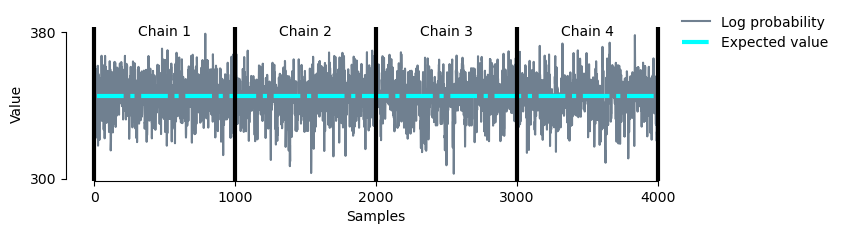

In [843]:
fig, ax = plt.subplots(figsize=(8, 2))

lw=3
clp_mean = 'cyan'
cchain = 'k'
ctext='k'

ax.plot(lp, label='Log probability', c='slategray')
ax.axhline(y=np.mean(lp), xmin=0.05, xmax=0.95, color=clp_mean, linestyle='-.', label='Expected value', lw=lw)
for i in range(0, n_chains+1):
    x = i * len(lp) // n_chains
    ax.axvline(x, color=cchain, linestyle='-', lw=lw)
    if i != 0:
        ax.text(x-n_samples//2, np.max(lp)-1, f'Chain {i}', color=ctext, fontsize=10, ha='center')
ax.set_ylabel('Value'); 
ax.set_xlabel('Samples'); 
modify_axis_spines(ax, which=['x','y'], yticks=[300, 380], xticks=np.linspace(0, lp.shape[0], 5))

fig.legend(bbox_to_anchor=(.88, 1), loc='upper left', frameon=False)
fig.savefig(fig_save_loc + '/ERP/Numpyro_validation_chains.svg', transparent=True)

The values of r_hat ~1 show the convergence. This convergence leads to a large effective sample size.

In [653]:
az.summary(mcmc, var_names=prm_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.490,0.111,0.277,0.686,0.004,0.003,845.0,509.0,1.00
g_2,0.699,0.002,0.694,0.704,0.000,0.000,646.0,693.0,1.01
g_3,0.146,0.019,0.108,0.180,0.001,0.001,479.0,554.0,1.01
g_4,0.210,0.027,0.154,0.256,0.001,0.001,488.0,553.0,1.01


### Posterior 

In [654]:
# Get posterior samples
posterior_samples = mcmc.get_samples(group_by_chain=True)
pooled_posterior_samples = mcmc.get_samples()

vizualize with arviz

In [655]:
az_obj = az.from_numpyro(mcmc)

showing the posterior samples of all chains

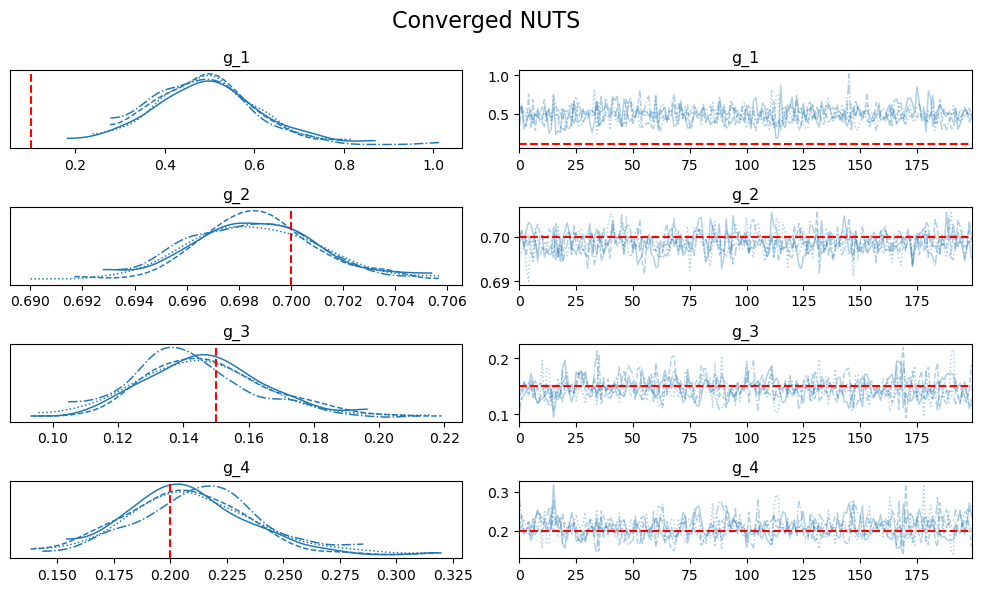

In [656]:
axes = az.plot_trace(
    az_obj,
    var_names=prm_names,
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')  
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
plt.gcf().suptitle("Converged NUTS", fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join((output_dir),"Posterior.png"), dpi=400)

In [657]:
chains_pooled = az_obj.posterior[prm_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

theta_prior = np.array([v for k,v in prior_predictions.items() if k in prm_names]).T
theta_pred = chains_pooled.copy().T
theta_pred_max = theta_pred.mean(0)

theta_prior.shape, theta_pred.shape

((100, 4), (800, 4))

In [663]:
pooled_posterior_predictive = Predictive(model=model, posterior_samples=pooled_posterior_samples, 
                                                      return_sites=['xpy_ppc'])
rng_key, rng_subkey = random.split(key=rng_key)
pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, data, prior_specs)

ppc_=pooled_posterior_predictive_samples['xpy_ppc']
xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=0)
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=0)

In [658]:
print(theta_true)
print(theta_pred_max)

[0.1  0.7  0.15 0.2 ]
[0.48969334 0.69862211 0.14591047 0.20968532]


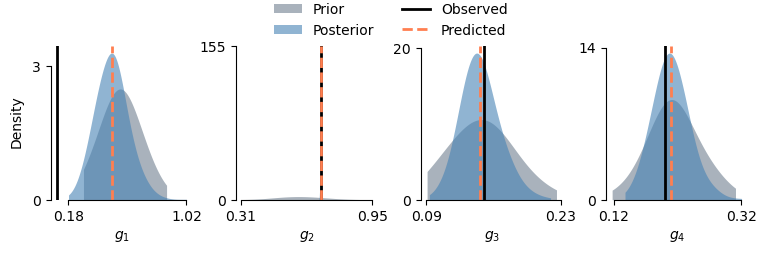

In [728]:
fig,axes = plt.subplots(1,4, figsize=(9,2))

truth_color = 'k'
pred_color = 'coral'
bw_adjust=2

for ax_ind, ax in enumerate(axes.ravel()):

    sns.kdeplot(theta_prior[:, ax_ind].ravel(), ax=ax, shade=True, linewidth=0, color='slategray', alpha=0.6, label='Prior', cut=0, bw_adjust=bw_adjust)
    sns.kdeplot(theta_pred[:, ax_ind], ax=ax, shade=True, linewidth=0, color='steelblue', alpha=0.6, label='Posterior', cut=0, bw_adjust=bw_adjust)
    ax.axvline(theta_true[ax_ind], ymin=0, c=truth_color, ls='-', label='Observed', lw=2)
    ax.axvline(theta_pred_max[ax_ind], ymin=0, c=pred_color, ls='--', label='Predicted', lw=2)
    ax.set_xlabel('$g_{}$'.format(ax_ind+1))
    ax.set_ylabel('')
    
    if ax_ind == 0:
        handles, labels = ax.get_legend_handles_labels()

    xmin = np.min([theta_prior[:, ax_ind].min(), theta_pred[:, ax_ind].min()])
    xmax = np.max([theta_prior[:, ax_ind].max(), theta_pred[:, ax_ind].max()])
    xround = 2

    modify_axis_spines(ax, which=['x','y'], xticks=[xmin.round(xround), xmax.round(xround)], yticks=[0, ax.get_ylim()[1].round()])

fig.supylabel('Density',x=0.08, fontsize=10)
fig.legend(handles, labels, frameon=False, loc=(0.35, 0.83), ncols=2)
fig.subplots_adjust(wspace=0.3)
fig.savefig(fig_save_loc + '/ERP/Numpyro_validation_posteriors.svg', transparent=True)

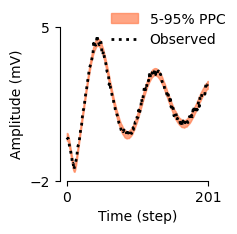

In [725]:
fig, ax = plt.subplots(figsize=(2,2))

markersize=10
lw=2
tend = data['nt_obs']

ax.fill_between(x=np.arange(xpy_obs.shape[0]), y1=xpy_per05_pooled, y2=xpy_per95_pooled, label='5-95% PPC', color=pred_color, alpha=0.7)
ax.plot(xpy_obs, lw=lw, label='Observed', c=truth_color, ls='dotted')

modify_axis_spines(ax, which=['x','y'], xticks=[0, tend], yticks=[xpy_obs.min().round()-1, xpy_obs.max().round()])
    
ax.set_xlabel('Time (step)')
ax.set_ylabel('Amplitude (mV)')

fig.legend(frameon=False)
fig.savefig(fig_save_loc + '/ERP/Numpyro_validation_erps.svg', transparent=True)

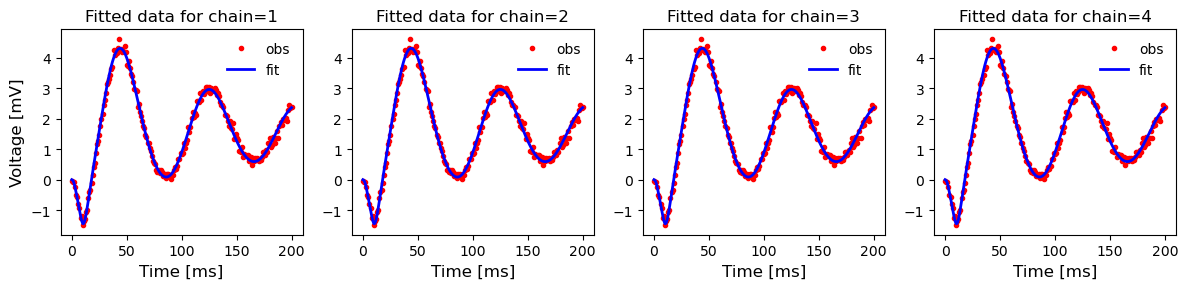

In [662]:
plot_fitted(data, az_obj.posterior);
# plt.savefig(os.path.join((output_dir),"Fits.png"), dpi=400)